In [5]:
import sys
import os

current_dir = os.getcwd()
project_root = os.path.dirname(current_dir)
sys.path.append(project_root)

import numpy as np
import matplotlib.pyplot as plt
import torch

from tiingo_data.download_data import get_daily_returns_data_cached
from utils import get_device
from core.data import create_multivariate_windows, train_val_split, prepare_data_for_chronos
from core.eval import (
    run_chronos_sliding_backtest,
    summarize_backtest_results,
    evaluate_model_on_test,
    compare_models,
)
from chronos import Chronos2Pipeline

In [6]:
# Load and prepare data
df_all = get_daily_returns_data_cached()
df_train_clean, df_eval_clean = prepare_data_for_chronos(df_all, test_size=1200)

print(f"Training data shape: {df_train_clean.shape}")
print(f"Eval data shape: {df_eval_clean.shape}")

# Hyperparameters
context_length = 200
prediction_length = 1
stride = 50
learning_rate = 1e-5
num_steps = 100
batch_size = 100

gics_level_1 = {
    "Information Technology": [
        "AAPL", "ADBE", "ADI", "AMD", "AMAT", "CSCO", "FIS",
        "IBM", "INTC", "INTU", "LRCX", "MSFT", "MU",
        "NVDA", "ORCL", "QCOM", "TXN"
    ],
    "Health Care": [
        "ABBV", "ABT", "AMGN", "BDX", "BMY", "CVS", "DHR",
        "ELV", "GILD", "HUM", "ISRG", "JNJ",
        "LLY", "MRK", "PFE", "REGN", "SYK", "TMO", "VRTX", "ZTS"
    ],
    "Financials": [
        "AIG", "AXP", "BAC", "BLK", "C", "CB", "CI",
        "COF", "GS", "JPM", "MET", "MS",
        "PNC", "PGR", "SCHW", "USB", "WFC"
    ],
    "Consumer Discretionary": [
        "AMZN", "BKNG", "HD", "LOW", "MCD",
        "META", "NFLX", "NKE", "SBUX",
        "TGT", "TJX"
    ],
    "Consumer Staples": [
        "CL", "COST", "EL", "KMB", "KO",
        "MDLZ", "MO", "PEP", "PG", "PM", "WMT"
    ],
    "Industrials": [
        "BA", "CAT", "CSX", "DE", "EMR",
        "ETN", "FDX", "GD", "GE", "HON",
        "ITW", "LMT", "MMM", "NSC",
        "RTX", "UNP", "UPS", "WM"
    ],
    "Energy": [
        "COP", "CVX", "EOG", "OXY", "SLB", "XOM"
    ],
    "Communication Services": [
        "CMCSA", "CRM", "GOOG", "GOOGL",
        "T", "TMUS", "VZ"
    ],
    "Materials": [
        "APD", "LIN", "SHW"
    ],
    "Real Estate": [
        "AMT", "SPG"
    ],
    "Utilities": [
        # nessuna delle aziende fornite rientra qui
    ],
}

def slugify(category: str) -> str:
    return (
        category.lower()
        .replace("&", "and")
        .replace("/", "_")
        .replace(" ", "_")
    )

# Create multivariate windows (full universe, no group IDs)
all_inputs = create_multivariate_windows(
    df_train_clean,
    context_length=context_length,
    prediction_length=prediction_length,
    stride=stride,
)
print(f"Total training windows: {len(all_inputs)}")
print(f"Each window shape: {all_inputs[0]['target'].shape}")

# Train/validation split (full universe)
train_inputs, val_inputs = train_val_split(all_inputs, val_ratio=0.1)
print(f"Train samples: {len(train_inputs)}, Val samples: {len(val_inputs)}")

# Build per-category datasets (train/val/eval)
category_datasets = {}
for category, tickers in gics_level_1.items():
    available = [ticker for ticker in tickers if ticker in df_train_clean.columns]
    if not available:
        continue
    category_train_df = df_train_clean[available]
    category_eval_df = df_eval_clean[available]
    category_inputs = create_multivariate_windows(
        category_train_df,
        context_length=context_length,
        prediction_length=prediction_length,
        stride=stride,
    )
    category_train_inputs, category_val_inputs = train_val_split(category_inputs, val_ratio=0.1)
    category_datasets[category] = {
        "tickers": available,
        "train_inputs": category_train_inputs,
        "val_inputs": category_val_inputs,
        "eval_df": category_eval_df,
        "output_dir": f"outputs/chronos2_sft/{slugify(category)}",
    }
    print(
        f"{category}: {len(available)} tickers, {len(category_train_inputs)} train, {len(category_val_inputs)} val"
    )

# Load model
pipeline = Chronos2Pipeline.from_pretrained(
    "amazon/chronos-2",
    device_map=get_device(),
    dtype=torch.float32,
)

print(f"Model device: {pipeline.model.device}")
print(f"Model dtype: {next(pipeline.model.parameters()).dtype}")

Training data shape: (2797, 114)
Eval data shape: (1200, 114)
Total training windows: 52
Each window shape: (114, 201)
Train samples: 46, Val samples: 6
Information Technology: 17 tickers, 46 train, 6 val
Health Care: 18 tickers, 46 train, 6 val
Financials: 17 tickers, 46 train, 6 val
Consumer Discretionary: 10 tickers, 46 train, 6 val
Consumer Staples: 11 tickers, 46 train, 6 val
Industrials: 18 tickers, 46 train, 6 val
Energy: 6 tickers, 46 train, 6 val
Communication Services: 6 tickers, 46 train, 6 val
Materials: 2 tickers, 46 train, 6 val
Real Estate: 2 tickers, 46 train, 6 val
Model device: cuda:0
Model dtype: torch.float32


In [7]:
print("Evaluating zero-shot model on test set...")
baseline_results = evaluate_model_on_test(
    pipeline=pipeline,
    df_test=df_eval_clean,
    context_length=context_length,
    n_samples=100,
)

print("\n=== ZERO-SHOT (Before Fine-tuning) ===")
print(f"Mean Quantile Loss: {baseline_results['mean_quantile_loss']:.6f} ± {baseline_results['std_quantile_loss']:.6f}")
print(f"Mean MSE: {baseline_results['mean_mse']:.6f}")
print(f"Mean MAE: {baseline_results['mean_mae']:.6f}")

Evaluating zero-shot model on test set...

=== ZERO-SHOT (Before Fine-tuning) ===
Mean Quantile Loss: 0.007240 ± 0.004854
Mean MSE: 0.000557
Mean MAE: 0.016263


In [8]:
# ============================
# Fine-tuning + eval usando best hyperparams dal CSV
# (rigenera windows coerenti -> evita "dataset is empty")
# ============================

from pathlib import Path
import pandas as pd
import gc
import torch

# già importati nel tuo notebook:
# - create_multivariate_windows, train_val_split
# - evaluate_model_on_test, compare_models
# - Chronos2Pipeline, get_device
# - df_train_clean, df_eval_clean, category_datasets

# ---------- cleanup VRAM/RAM ----------
def cleanup_cuda():
    gc.collect()
    if torch.cuda.is_available():
        try:
            torch.cuda.synchronize()
        except Exception:
            pass
        torch.cuda.empty_cache()
        try:
            torch.cuda.ipc_collect()
        except Exception:
            pass

# ---------- load best hparams CSV ----------
CSV_CANDIDATES = [
    Path("notebooks/outputs/tuning_results/tuning_best_results.csv"),
    Path("outputs/tuning_results/tuning_best_results.csv"),
]
best_csv_path = next((p for p in CSV_CANDIDATES if p.exists()), None)
if best_csv_path is None:
    raise FileNotFoundError(
        "Non trovo tuning_best_results.csv. Ho cercato:\n" + "\n".join(map(str, CSV_CANDIDATES))
    )

df_best = pd.read_csv(best_csv_path)
df_best["group"] = df_best["group"].astype(str).str.strip()
hp_by_group = df_best.set_index("group").to_dict(orient="index")

def get_hparams(group: str):
    g = str(group).strip()
    if g not in hp_by_group:
        raise KeyError(f"Group '{g}' non presente nel CSV. Disponibili: {sorted(hp_by_group.keys())}")
    row = hp_by_group[g]
    return dict(
        prediction_length=int(row["prediction_length"]),
        context_length=int(row["context_length"]),
        num_steps=int(row["num_steps"]),
        batch_size=int(row["batch_size"]),
        learning_rate=float(row["learning_rate"]),
        stride=int(row.get("stride", 50)),  # se nel CSV non c'è, default 50
    )

# ---------- helper per creare train/val inputs coerenti ----------
def make_train_val_inputs(df_wide, hp, val_ratio=0.1):
    windows = create_multivariate_windows(
        df_wide,
        context_length=hp["context_length"],
        prediction_length=hp["prediction_length"],
        stride=hp["stride"],
    )
    tr, va = train_val_split(windows, val_ratio=val_ratio)
    del windows
    cleanup_cuda()
    return tr, va

# ---------- (opzionale) carico pipeline "base" pulita ----------
# Consiglio: usare float32 come nel tuo codice (più stabile, più VRAM).
# Se vuoi meno VRAM e la tua GPU lo supporta, puoi mettere dtype=torch.float16 o bf16.
def load_base_pipeline(dtype=torch.float32):
    return Chronos2Pipeline.from_pretrained(
        "amazon/chronos-2",
        device_map=get_device(),
        dtype=dtype,
    )

# ============================
# 1) Fine-tune GLOBAL
# ============================
cleanup_cuda()
global_hp = get_hparams("global")

print(
    f"\n[GLOBAL] hp: steps={global_hp['num_steps']} lr={global_hp['learning_rate']} "
    f"ctx={global_hp['context_length']} pred={global_hp['prediction_length']} "
    f"bs={global_hp['batch_size']} stride={global_hp['stride']}"
)

# se vuoi partire dal modello base (consigliato), ricarica una pipeline pulita:
pipeline_global = load_base_pipeline(dtype=torch.float32)

global_train_inputs, global_val_inputs = make_train_val_inputs(df_train_clean, global_hp, val_ratio=0.1)

finetuned_general = pipeline_global.fit(
    inputs=global_train_inputs,
    validation_inputs=global_val_inputs,
    prediction_length=global_hp["prediction_length"],
    context_length=global_hp["context_length"],
    min_past=global_hp["context_length"],
    num_steps=global_hp["num_steps"],
    batch_size=global_hp["batch_size"],
    learning_rate=global_hp["learning_rate"],
    finetune_mode="full",
    output_dir="outputs/chronos2_sft/general",
)

del global_train_inputs, global_val_inputs, pipeline_global
cleanup_cuda()

print("\nEvaluating fine-tuned general model on test set...")
general_results = evaluate_model_on_test(
    pipeline=finetuned_general,
    df_test=df_eval_clean,
    context_length=global_hp["context_length"],
    n_samples=100,
)

print("\n=== GENERAL FINE-TUNED (SFT) ===")
print(f"Mean Quantile Loss: {general_results['mean_quantile_loss']:.6f} ± {general_results['std_quantile_loss']:.6f}")
print(f"Mean MSE: {general_results['mean_mse']:.6f}")
print(f"Mean MAE: {general_results['mean_mae']:.6f}")

# ============================
# 2) Per-category: fit -> eval -> compare -> cleanup
# ============================
category_comparisons = {}

for category, payload in category_datasets.items():
    cleanup_cuda()

    cat_hp = get_hparams(category)
    available = [t for t in payload["tickers"] if t in df_train_clean.columns]
    if not available:
        print(f"\n[{category}] skip: nessun ticker disponibile nel training df.")
        continue

    print(
        f"\n[{category}] hp: steps={cat_hp['num_steps']} lr={cat_hp['learning_rate']} "
        f"ctx={cat_hp['context_length']} pred={cat_hp['prediction_length']} "
        f"bs={cat_hp['batch_size']} stride={cat_hp['stride']} | tickers={len(available)}"
    )

    cat_train_df = df_train_clean[available]

    # pipeline base pulita per evitare "contaminazione" da fine-tune precedente
    pipeline_cat = load_base_pipeline(dtype=torch.float32)

    cat_train_inputs, cat_val_inputs = make_train_val_inputs(cat_train_df, cat_hp, val_ratio=0.1)

    cat_model = pipeline_cat.fit(
        inputs=cat_train_inputs,
        validation_inputs=cat_val_inputs,
        prediction_length=cat_hp["prediction_length"],
        context_length=cat_hp["context_length"],
        min_past=cat_hp["context_length"],
        num_steps=cat_hp["num_steps"],
        batch_size=cat_hp["batch_size"],
        learning_rate=cat_hp["learning_rate"],
        finetune_mode="full",
        output_dir=payload["output_dir"],
    )

    # libera ASAP le windows e la pipeline base
    del cat_train_inputs, cat_val_inputs, pipeline_cat
    cleanup_cuda()

    print(f"Evaluating category: {category}")
    category_results = evaluate_model_on_test(
        pipeline=cat_model,
        df_test=payload["eval_df"],
        context_length=cat_hp["context_length"],
        n_samples=100,
    )

    general_category_results = evaluate_model_on_test(
        pipeline=finetuned_general,
        df_test=payload["eval_df"],
        context_length=global_hp["context_length"],
        n_samples=100,
    )

    comparison = compare_models(general_cate    gory_results, category_results)

    category_comparisons[category] = {
        "general": general_category_results,
        "category": category_results,
        "comparison": comparison,
        "hparams_category": cat_hp,
        "hparams_global": global_hp,
    }

    print(f"  General Quantile Loss: {general_category_results['mean_quantile_loss']:.6f}")
    print(f"  Category Quantile Loss: {category_results['mean_quantile_loss']:.6f}")
    print(f"  Quantile Loss Improvement: {comparison['quantile_loss_improvement']:+.2f}%")
    print(f"  MSE Improvement: {comparison['mse_improvement']:+.2f}%")
    print(f"  MAE Improvement: {comparison['mae_improvement']:+.2f}%")

    # IMPORTANT: drop model categoria per liberare VRAM
    del cat_model
    cleanup_cuda()



[GLOBAL] hp: steps=1500 lr=3.113813151474403e-06 ctx=128 pred=1 bs=48 stride=100


Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss,Validation Loss
100,0.506500,0.510672
200,0.419700,0.516718
300,0.377500,0.550902
400,0.336400,0.546959
500,0.299300,0.536377
600,0.277100,0.561504
700,0.268700,0.573781
800,0.245500,0.567060
900,0.242000,0.585520
1000,0.233200,0.585800



Evaluating fine-tuned general model on test set...

=== GENERAL FINE-TUNED (SFT) ===
Mean Quantile Loss: 0.005894 ± 0.003132
Mean MSE: 0.000426
Mean MAE: 0.013765

[Information Technology] hp: steps=1500 lr=4.757865681955919e-05 ctx=96 pred=2 bs=48 stride=100 | tickers=17


Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss,Validation Loss
100,0.601000,1.728489
200,0.261600,1.726988
300,0.197200,1.686187
400,0.141300,1.727487
500,0.117400,1.718441
600,0.098000,1.798778
700,0.086700,1.779180
800,0.080500,1.780855
900,0.071000,1.781605
1000,0.063900,1.818507


Evaluating category: Information Technology
  General Quantile Loss: 0.007882
  Category Quantile Loss: 0.007754
  Quantile Loss Improvement: +1.62%
  MSE Improvement: +22.35%
  MAE Improvement: +8.90%

[Health Care] hp: steps=600 lr=1.8494433914224897e-05 ctx=192 pred=2 bs=56 stride=50 | tickers=18


Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss,Validation Loss
100,0.854700,0.829753
200,0.437300,0.977510
300,0.277000,0.983272
400,0.212600,1.037125
500,0.170300,1.037706
600,0.154500,1.037740


Evaluating category: Health Care
  General Quantile Loss: 0.005363
  Category Quantile Loss: 0.005412
  Quantile Loss Improvement: -0.91%
  MSE Improvement: +12.23%
  MAE Improvement: -0.13%

[Financials] hp: steps=200 lr=3.6919130330522415e-06 ctx=192 pred=2 bs=88 stride=75 | tickers=17


Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss,Validation Loss
100,0.854800,1.172338
200,0.608100,1.238631


Evaluating category: Financials
  General Quantile Loss: 0.005892
  Category Quantile Loss: 0.005926
  Quantile Loss Improvement: -0.57%
  MSE Improvement: +4.31%
  MAE Improvement: +4.98%

[Consumer Discretionary] hp: steps=200 lr=4.85841149653781e-05 ctx=192 pred=5 bs=96 stride=100 | tickers=10


Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss,Validation Loss
100,1.104500,2.729068
200,0.341100,2.849384


Evaluating category: Consumer Discretionary
  General Quantile Loss: 0.006590
  Category Quantile Loss: 0.006382
  Quantile Loss Improvement: +3.15%
  MSE Improvement: +24.99%
  MAE Improvement: +8.60%

[Consumer Staples] hp: steps=600 lr=4.588132396264929e-05 ctx=256 pred=1 bs=96 stride=75 | tickers=11


Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss,Validation Loss
100,0.227700,0.726563
200,0.063600,0.811583
300,0.042600,0.805746
400,0.033600,0.787597
500,0.025300,0.792881
600,0.020700,0.805190


Evaluating category: Consumer Staples
  General Quantile Loss: 0.004506
  Category Quantile Loss: 0.004811
  Quantile Loss Improvement: -6.75%
  MSE Improvement: +24.62%
  MAE Improvement: +2.01%

[Industrials] hp: steps=1300 lr=9.19203063802769e-06 ctx=192 pred=2 bs=72 stride=100 | tickers=18


Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss,Validation Loss
100,0.737800,1.004362
200,0.357300,1.004686
300,0.249000,1.034164
400,0.203500,0.965829
500,0.173100,1.034955
600,0.152700,1.021500
700,0.144400,1.005978
800,0.131800,1.030273
900,0.126600,1.038545
1000,0.118700,1.027835


Evaluating category: Industrials
  General Quantile Loss: 0.005315
  Category Quantile Loss: 0.005915
  Quantile Loss Improvement: -11.30%
  MSE Improvement: +4.08%
  MAE Improvement: -2.65%

[Energy] hp: steps=300 lr=4.968573113330312e-05 ctx=256 pred=4 bs=8 stride=100 | tickers=6


Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss,Validation Loss
100,1.510800,2.365561
200,0.622500,2.460433
300,0.307300,2.487113


Evaluating category: Energy
  General Quantile Loss: 0.006228
  Category Quantile Loss: 0.005800
  Quantile Loss Improvement: +6.86%
  MSE Improvement: +19.21%
  MAE Improvement: +8.38%

[Communication Services] hp: steps=1500 lr=2.1824625252932308e-05 ctx=128 pred=5 bs=32 stride=75 | tickers=6


Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss,Validation Loss
100,1.515100,3.638767
200,0.579000,3.756300
300,0.431200,3.756949
400,0.355900,3.745381
500,0.307500,3.874751
600,0.283100,3.812816
700,0.254600,3.798996
800,0.238300,3.847873
900,0.222300,3.793112
1000,0.208500,3.852093


Evaluating category: Communication Services
  General Quantile Loss: 0.005718
  Category Quantile Loss: 0.006092
  Quantile Loss Improvement: -6.54%
  MSE Improvement: -5.19%
  MAE Improvement: -2.06%

[Materials] hp: steps=1300 lr=4.749675495827024e-05 ctx=64 pred=2 bs=16 stride=75 | tickers=2


Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss,Validation Loss
100,0.488200,1.316667
200,0.167900,1.242597
300,0.121600,1.288507
400,0.097100,1.333693
500,0.086000,1.303529
600,0.075900,1.295127
700,0.065200,1.247798
800,0.058500,1.337141
900,0.050800,1.311084
1000,0.046900,1.305640


Evaluating category: Materials
  General Quantile Loss: 0.005795
  Category Quantile Loss: 0.006763
  Quantile Loss Improvement: -16.69%
  MSE Improvement: +18.66%
  MAE Improvement: -6.95%

[Real Estate] hp: steps=1500 lr=4.533506326014935e-05 ctx=256 pred=4 bs=8 stride=75 | tickers=2


Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss,Validation Loss
100,1.079600,4.535813
200,0.470000,4.256453
300,0.377200,4.217503
400,0.292000,4.478166
500,0.255900,4.438995
600,0.199700,4.435638
700,0.188600,4.547798
800,0.177700,4.451775
900,0.161400,4.525916
1000,0.139200,4.532964


Evaluating category: Real Estate
  General Quantile Loss: 0.006301
  Category Quantile Loss: 0.005326
  Quantile Loss Improvement: +15.48%
  MSE Improvement: +40.30%
  MAE Improvement: +19.95%


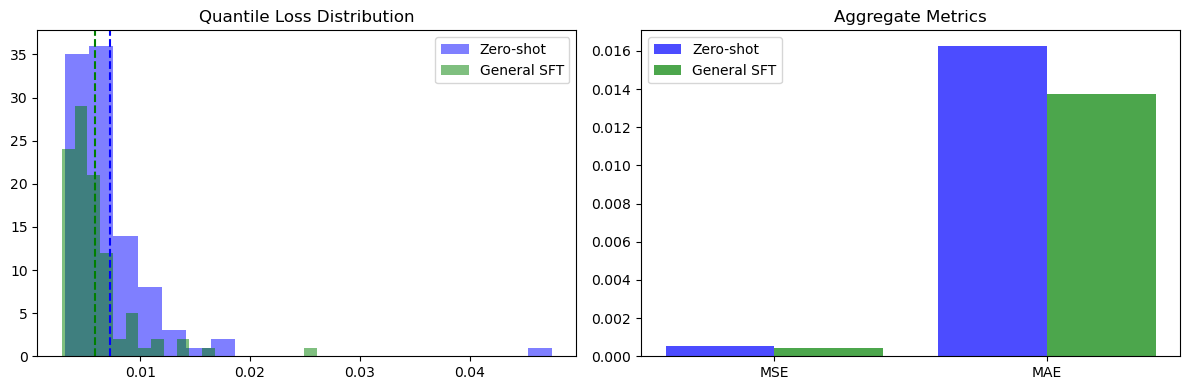

In [9]:
# Visualize loss distributions
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Quantile loss distribution
axes[0].hist(baseline_results['quantile_losses'], bins=20, alpha=0.5, label='Zero-shot', color='blue')
axes[0].hist(general_results['quantile_losses'], bins=20, alpha=0.5, label='General SFT', color='green')
axes[0].axvline(baseline_results['mean_quantile_loss'], color='blue', linestyle='--')
axes[0].axvline(general_results['mean_quantile_loss'], color='green', linestyle='--')
axes[0].set_title('Quantile Loss Distribution')
axes[0].legend()

# Bar chart for aggregate metrics
metrics = ['mean_mse', 'mean_mae']
baseline_vals = [baseline_results[m] for m in metrics]
general_vals = [general_results[m] for m in metrics]

x = np.arange(len(metrics))
axes[1].bar(x - 0.2, baseline_vals, width=0.4, label='Zero-shot', color='blue', alpha=0.7)
axes[1].bar(x + 0.2, general_vals, width=0.4, label='General SFT', color='green', alpha=0.7)
axes[1].set_xticks(x)
axes[1].set_xticklabels(['MSE', 'MAE'])
axes[1].set_title('Aggregate Metrics')
axes[1].legend()

plt.tight_layout()
plt.show()

In [ ]:
# Run sliding backtest on evaluation data
results = run_chronos_sliding_backtest(
    pipeline=finetuned_general,
    df_returns=df_eval_clean,
    device=torch.device(get_device()),
    context_length=context_length,
)

print(summarize_backtest_results(results))

  0%|          | 0/999 [00:00<?, ?it/s]


RuntimeError: cannot pin 'torch.cuda.FloatTensor' only dense CPU tensors can be pinned

In [ ]:
# Detailed analysis
preds = results["preds"]   # (T_eval, N)
trues = results["trues"]   # (T_eval, N)
dates = results["dates"]

# Plot correlation over time
correlations = [m["corr"] for m in results["daily_metrics"]]
plt.figure(figsize=(12, 4))
plt.plot(dates, correlations)
plt.axhline(y=0, color='r', linestyle='--')
plt.title("Daily Cross-Sectional Correlation")
plt.xlabel("Date")
plt.ylabel("Correlation")
plt.show()

# Distribution of correlations
plt.figure(figsize=(8, 4))
plt.hist(correlations, bins=50)
plt.axvline(x=np.mean(correlations), color='r', label=f'Mean: {np.mean(correlations):.4f}')
plt.title("Distribution of Daily Correlations")
plt.legend()
plt.show()